In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
feature_df = pd.read_csv('data/systematic/features.csv')
target_df  = pd.read_csv('data/systematic/target.csv')

# Drop the specified columns from target_df
target_df_filtered = target_df.drop(columns=['sequenceID', 'max.log.lambda'])

# Concatenate feature_df and the filtered target_df
feature_target_df = pd.concat([feature_df, target_df_filtered], axis=1)

In [3]:
# Replace -inf with NaN
feature_target_df['min.log.lambda'].replace(-np.inf, np.nan, inplace=True)

# Drop rows with NaN values in column 'min.log.lambda'
feature_target_df = feature_target_df.dropna(subset=['min.log.lambda'])

In [4]:
X = torch.tensor(feature_target_df[list(feature_target_df.columns)[1:-1]].values, dtype=torch.float32)
y = torch.tensor(feature_target_df['min.log.lambda'].values, dtype=torch.float32).unsqueeze(1)

In [5]:
# number of features
nof = X.shape[1]
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(nof, nof)
        self.fc2 = nn.Linear(nof, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Initialize the model
model = SimpleNN()

In [7]:
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Initialize early stopping parameters
patience = 1000
best_loss = np.inf
epochs_without_improvement = 0

# Train the model
epochs = 1000000
for epoch in range(epochs):
    model.train()

    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Check for early stopping
    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0  # Reset counter
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Stopping early at epoch {epoch + 1}")
        break

Stopping early at epoch 154436


In [16]:
# Get the model's weights
weights = model.fc1.weight.data.numpy()

# Analyze the weights to infer feature importance
feature_importance = weights.sum(axis=0)

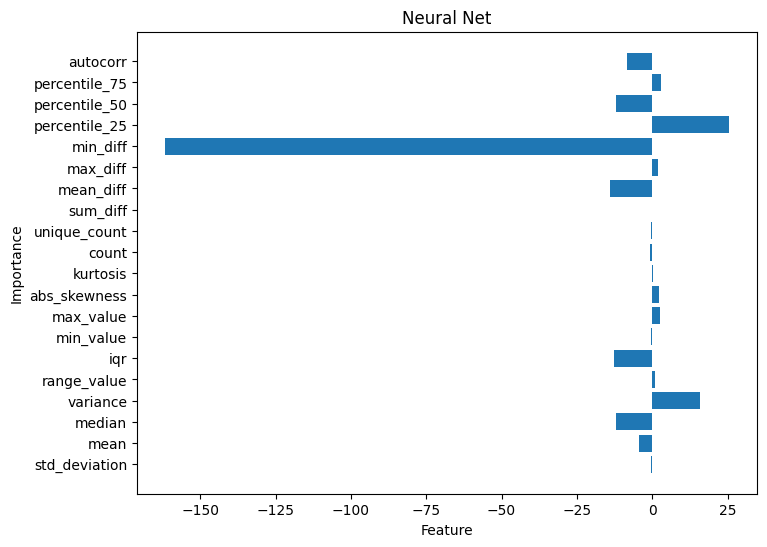

In [17]:
plt.figure(figsize=(8, 6))
plt.barh(feature_target_df.columns[1:-1], feature_importance)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Neural Net")
# plt.savefig("figs/neural_net.png", format='png')
plt.show()